In [17]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from UNet import UNet  # or from unet import UNetSimple if you prefer the smaller version
from loss_function import CombinedLoss
from train_test import train_model
from train_test import evaluate_model
from train_test import evaluate_model_sr

In [18]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

# importlib.reload(preprocessing)
# from preprocessing import preprocess_data

# from model_eval_plotting import evaluate_model
# from model_eval_plotting import plot_predictions_vs_targets

# from CNN_setup import SimpleCNN
# from CNN_setup import TensorDataset

# from gcm_filtering import filter_inputs_dataset
# from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

# Data Pre-processing

In [19]:
ds_HR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 
ds_HR

<xarray.Dataset> Size: 342GB
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 731)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time          (time) object 6kB 0181-01-01 12:00:00 ... 0200-12-27 12:00:00
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [20]:
ds_LR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_LR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 
ds_LR

<xarray.Dataset> Size: 171GB
Dimensions:       (time: 731, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 6kB 0181-01-01 12:00:00 ... 0200-12-27 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [21]:
ds_SGS = ds_HR - ds_LR
ds_SGS

<xarray.Dataset> Size: 171GB
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 731)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time          (time) object 6kB 0181-01-01 12:00:00 ... 0200-12-27 12:00:00
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

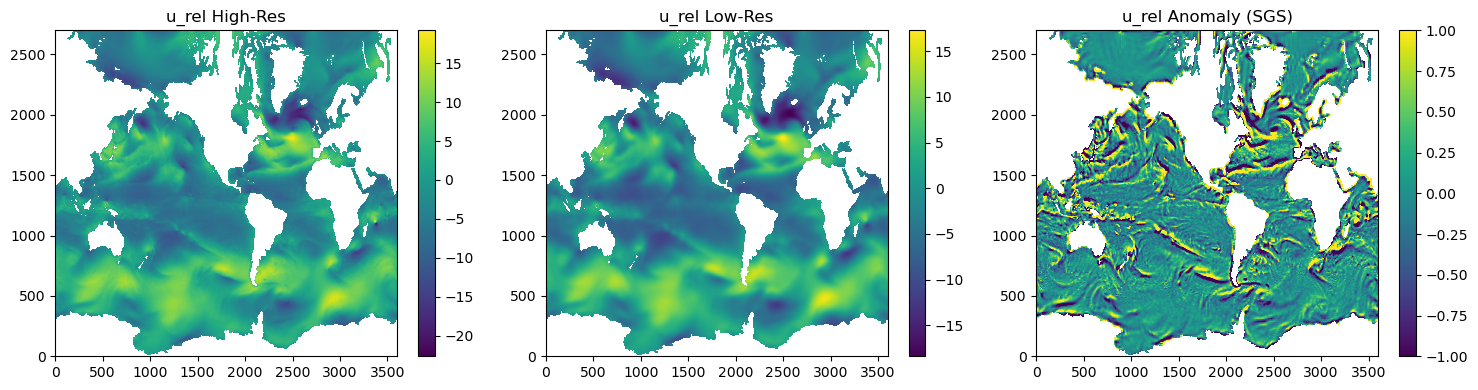

In [25]:
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # Wider figure for 3 plots

# Plot 1: High-resolution
im1 = axes[0].pcolor(ds_HR.u_relative.isel(time=0))
axes[0].set_title("u_rel High-Res")
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot 2: Low-resolution
im2 = axes[1].pcolor(ds_LR.u_relative.isel(time=0))
axes[1].set_title("u_rel Low-Res")
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Plot 3: Model output (replace with actual variable if needed)
im3 = axes[2].pcolor(ds_SGS.u_relative.isel(time=0), vmin=-1, vmax=1)
axes[2].set_title("u_rel Anomaly (SGS)")
fig.colorbar(im3, ax=axes[2], orientation='vertical')

# Adjust layout
plt.tight_layout()  # Automatically adjusts spacing nicely

# Show plot
plt.show()


In [22]:
# Select region of interest
ds_SGS_reg = ds_SGS.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_HR_reg = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_LR_reg = ds_LR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))

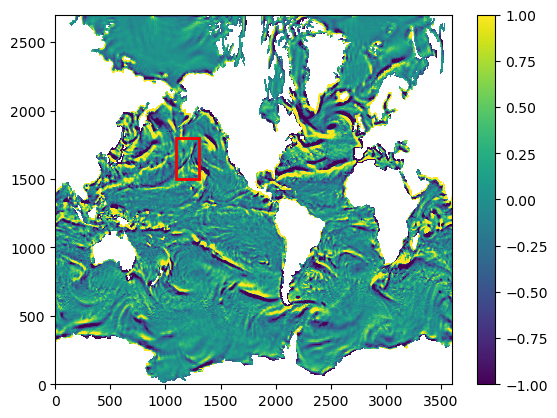

In [9]:
# Extract the data for the specific region
data = ds_SGS.u_relative.isel(time=0)

# Plot the data using pcolor
plt.pcolor(data, cmap='viridis', vmin=-1, vmax=1)

# Get the bounds of the region (using the indices)
x_min, x_max = 1100, 1300
y_min, y_max = 1500, 1800

# Draw a rectangle around the region (the coordinates are based on the index positions)
rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='red', facecolor='none')
plt.gca().add_patch(rect)  # Add the rectangle to the current axes

# Show the plot
plt.colorbar()
plt.show()


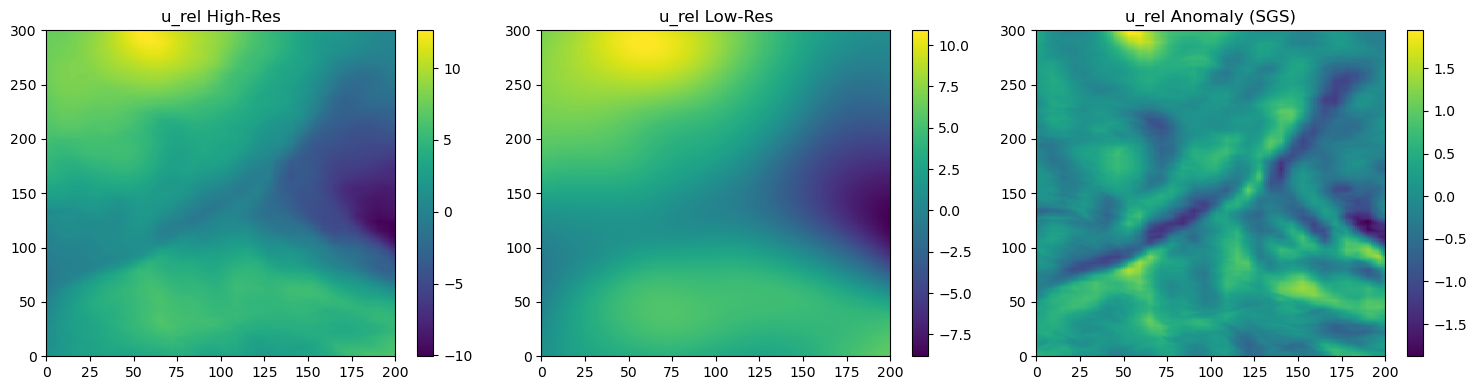

In [10]:
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # Wider figure for 3 plots

# Plot 1: High-resolution
im1 = axes[0].pcolor(ds_HR_reg.u_relative.isel(time=0))
axes[0].set_title("u_rel High-Res")
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot 2: Low-resolution
im2 = axes[1].pcolor(ds_LR_reg.u_relative.isel(time=0))
axes[1].set_title("u_rel Low-Res")
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Plot 3: Model output (replace with actual variable if needed)
im3 = axes[2].pcolor(ds_SGS_reg.u_relative.isel(time=0))
axes[2].set_title("u_rel Anomaly (SGS)")
fig.colorbar(im3, ax=axes[2], orientation='vertical')

# Adjust layout
plt.tight_layout()  # Automatically adjusts spacing nicely

# Show plot
plt.show()


In [30]:
# Total number of samples
n_samples = len(ds_LR_reg.time)  # Assuming 'time' is the dimension

# Generate random indices
indices = np.arange(n_samples)
np.random.shuffle(indices)

# Split indices for training, validation, and testing
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Select data using the indices
# SGS
train_data_SGS = ds_SGS_reg.isel(time=train_indices)
val_data_SGS = ds_SGS_reg.isel(time=val_indices)
test_data_SGS = ds_SGS_reg.isel(time=test_indices)
# LR
train_data_LR = ds_LR_reg.isel(time=train_indices)
val_data_LR = ds_LR_reg.isel(time=val_indices)
test_data_LR = ds_LR_reg.isel(time=test_indices)
# HR
test_data_HR = ds_HR_reg.isel(time=test_indices)

print("Training set size:", len(train_data_SGS.time))
print("Validation set size:", len(val_data_SGS.time))
print("Testing set size:", len(test_data_SGS.time))

Training set size: 511
Validation set size: 109
Testing set size: 111


In [31]:
# Extract HR data
urel_SGS_train = train_data_SGS.u_relative.values ## training
urel_SGS_val = val_data_SGS.u_relative.values ## validation
urel_SGS_test = test_data_SGS.u_relative ## testing

# Extract LR data
urel_LR_train = train_data_LR.u_relative.values ## training
urel_LR_val = val_data_LR.u_relative.values ## validation
urel_LR_test = test_data_LR.u_relative.values ## testing

# Extract HR data
urel_HR_test = test_data_HR.u_relative.values ## testing

In [25]:
x_train = torch.tensor(urel_LR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_train = torch.tensor(urel_SGS_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_val = torch.tensor(urel_LR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_val = torch.tensor(urel_SGS_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_test = torch.tensor(urel_LR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
# y_test = torch.tensor(urel_SGS_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

In [26]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, torch.zeros(len(x_test)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [27]:
model = UNet()
model

UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv1_1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

# Case 1: u_rel SGS anomaly prediction, MSELoss

In [12]:
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_case_urelSGS.pth',
            n_epochs=100) # n_epochs=2000)

Trainable Parameters: 2314881
Resuming from epoch 50 with best val losses [0.024150131885474976, 0.02329457158205706, 0.02373812146006374, 0.02315450698957531, 0.02244536520554385]
Epoch 51, Train Loss: 2.041e-02, Val Loss: 2.032e-02, Epoch Time: 155.28s
Best model so far saved to ./model_case_urelSGS.pth
Epoch 52, Train Loss: 1.905e-02, Val Loss: 1.848e-02, Epoch Time: 153.51s
Best model so far saved to ./model_case_urelSGS.pth
Epoch 53, Train Loss: 1.810e-02, Val Loss: 1.993e-02, Epoch Time: 151.03s
Epoch 54, Train Loss: 1.924e-02, Val Loss: 2.149e-02, Epoch Time: 149.65s
Epoch 55, Train Loss: 1.847e-02, Val Loss: 2.067e-02, Epoch Time: 149.72s
Epoch 56, Train Loss: 1.830e-02, Val Loss: 1.982e-02, Epoch Time: 149.86s
Epoch 57, Train Loss: 1.754e-02, Val Loss: 2.007e-02, Epoch Time: 150.55s
Epoch 58, Train Loss: 1.651e-02, Val Loss: 2.291e-02, Epoch Time: 150.72s
Patience counter: 1/50
Epoch 59, Train Loss: 1.649e-02, Val Loss: 2.027e-02, Epoch Time: 151.25s
Epoch 60, Train Loss: 1.62

In [28]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, urel_SGS_test, './model_case_urelSGS.pth')
sr_pred

Loaded model parameters from ./model_case_urelSGS.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[-2.29965508e-01, -3.43034059e-01, -3.56742918e-01, ...,
         -5.07208228e-01, -3.92557263e-01, -2.29640633e-01],
        [-1.84924111e-01,  1.36316121e-02, -2.12277502e-01, ...,
         -3.57877761e-01, -5.75444579e-01, -3.73035043e-01],
        [-2.27160871e-01,  8.62585008e-03, -2.83638626e-01, ...,
         -3.79580557e-01, -4.25348073e-01, -3.56668025e-01],
        ...,
        [-1.70773327e+00, -1.93169820e+00, -2.03794479e+00, ...,
         -2.29344293e-01, -2.81191647e-01, -2.38597870e-01],
        [-1.52368355e+00, -1.74963999e+00, -1.86332464e+00, ...,
         -2.52983063e-01, -3.06705981e-01, -2.27998346e-01],
        [-9.16689813e-01, -1.43844533e+00, -1.67665100e+00, ...,
         -2.01092750e-01, -2.29645655e-01, -1.70843869e-01]],

       [[-2.99975634e-01, -4.18078005e-01, -4.20646310e-01, ...,
         -3.50344956e-01, -2.11196810e-01, -1.66142911e-01],
        [-2.92658985e-01, -1.17493801e-01, -3.11792016e-01, ...,
         -3.39221448e-01, -3.47072065e-01, -2.23791271e-01],
        [-3.80522609e-01, -2.27957457e-01, -4.23867702e-01, ...,
         -3.23375225e-01, -3.18198681e-01, -2.48446926e-01],
...
          5.99343538e-01,  4.36934471e-01,  5.41993141e-01],
        [-1.09445047e+00, -1.19039893e+00, -1.24689937e+00, ...,
          2.77402222e-01,  6.26395345e-01,  5.40805936e-01],
        [-6.46400452e-01, -1.01997185e+00, -1.13529408e+00, ...,
          5.13505101e-01,  4.98059511e-01,  4.95389342e-01]],

       [[-2.06299260e-01, -2.98315942e-01, -3.35547149e-01, ...,
          1.94638401e-01,  1.95388749e-01,  3.45254801e-02],
        [-1.57433420e-01,  9.30073261e-02, -1.99100435e-01, ...,
          1.89192802e-01,  7.78521150e-02,  1.62700400e-01],
        [-1.62613243e-01,  1.37576401e-01, -2.13492990e-01, ...,
          2.07203358e-01,  1.77153796e-01,  2.51332968e-01],
        ...,
        [-1.26105952e+00, -1.48965263e+00, -1.57663071e+00, ...,
         -6.43192887e-01, -6.22728467e-01, -5.45025706e-01],
        [-1.06250906e+00, -1.30165529e+00, -1.36957240e+00, ...,
         -4.64024723e-01, -4.83309597e-01, -4.20769632e-01],
        [-6.80261314e-01, -8.43284369e-01, -9.75902915e-01, ...,
         -4.07686114e-01, -3.57174754e-01, -3.22396964e-01]]],
      shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0191-04-19 12:00:00 ... 0198-04-12 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

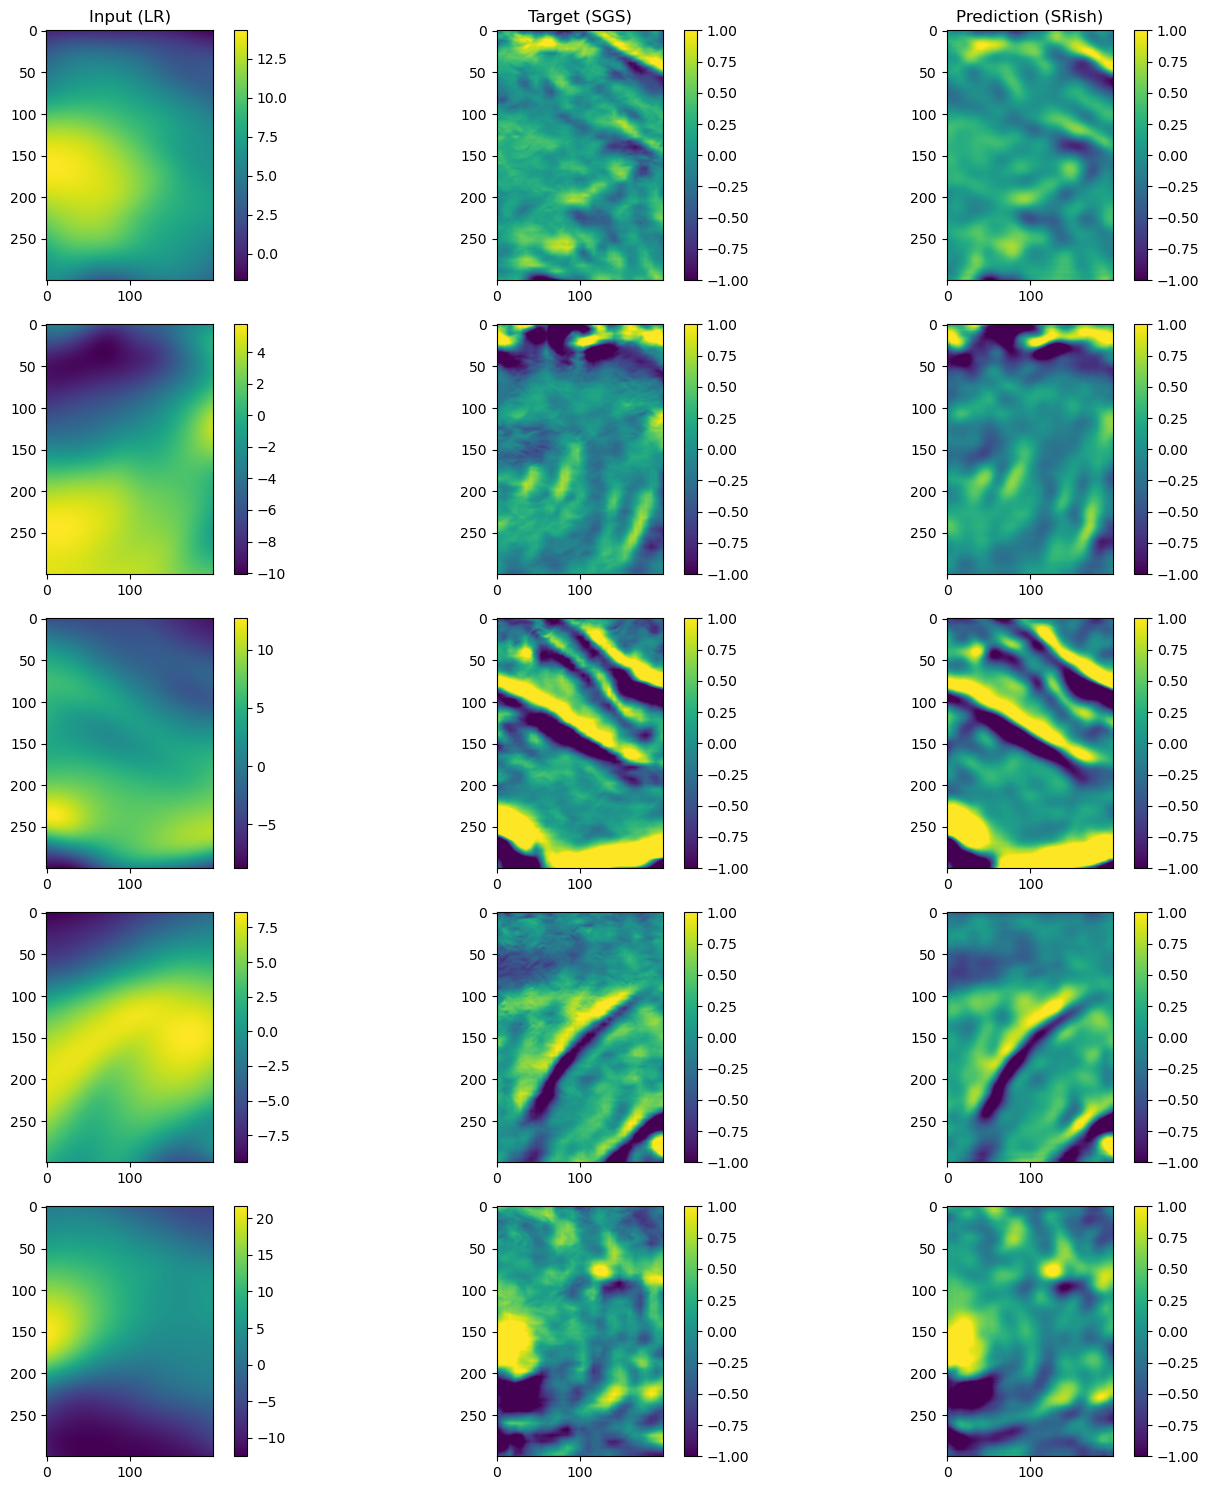

In [14]:
num_samples = 5

# Create figure with 5 rows and 3 columns
fig, axs = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

# Now plot all images with shared vmin/vmax
for i in range(num_samples):
    d1 = urel_LR_test[i,:,:] 
    d2 = urel_SGS_test[i,:,:]
    d3 = sr_pred[i,:,:]

    # Min/Max Calculation
    # vmin = min(d2.min().compute().item(), d3.min().compute().item())
    # vmax = max(d2.max().compute().item(), d3.max().compute().item())
    
    # Input (LR)
    im1 = axs[i, 0].imshow(d1, cmap='viridis', vmin=d1.min().item(), vmax=d1.max().item())
    if i == 0:
        axs[i, 0].set_title('Input (LR)')
    plt.colorbar(im1, ax=axs[i, 0], fraction=0.046, pad=0.04)

    # Output (HR)
    im2 = axs[i, 1].imshow(d2, cmap='viridis', vmin=-1, vmax=1)
    if i == 0:
        axs[i, 1].set_title('Target (SGS)')
    plt.colorbar(im2, ax=axs[i, 1], fraction=0.046, pad=0.04)

    # Prediction (SR)
    im3 = axs[i, 2].imshow(d3, cmap='viridis', vmin=-1, vmax=1)
    if i == 0:
        axs[i, 2].set_title('Prediction (SRish)')
    plt.colorbar(im3, ax=axs[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


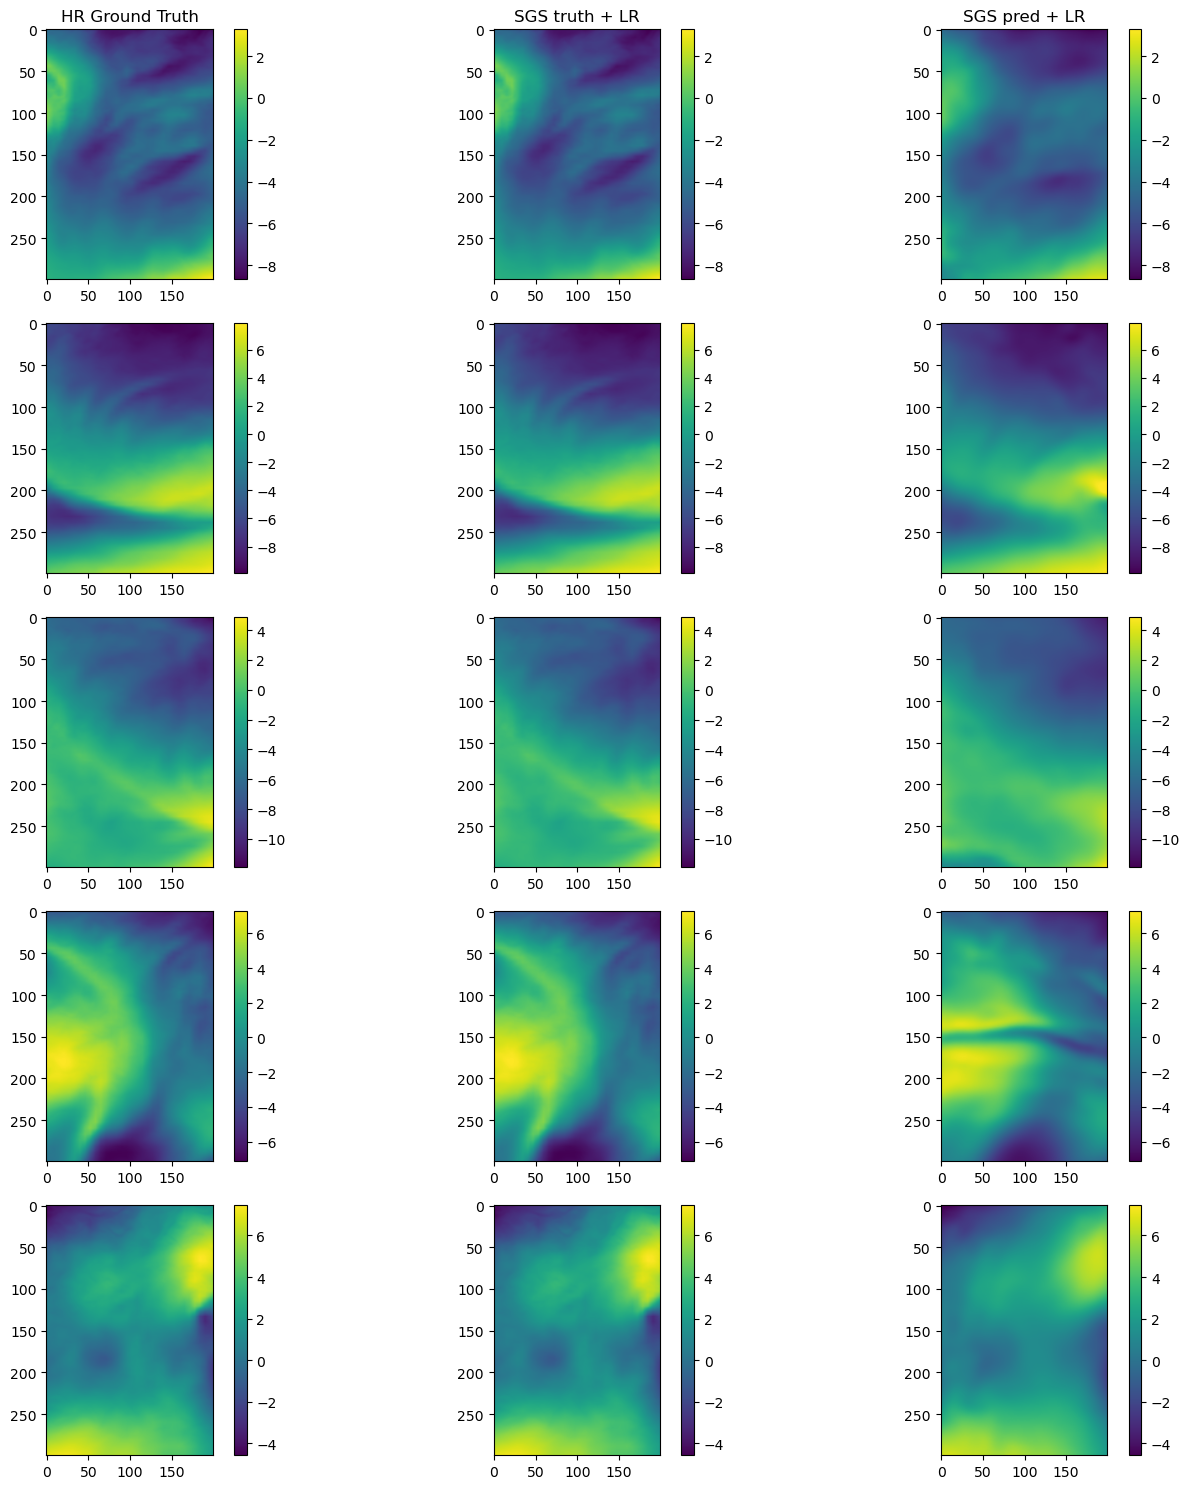

In [42]:
num_samples = 5

# Create figure with 5 rows and 3 columns
fig, axs = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

# Now plot all images with shared vmin/vmax
for i in range(num_samples):
    d1 = urel_HR_test[i,:,:] 
    d2 = urel_LR_test[i,:,:] + urel_SGS_test[i,:,:]
    d3 = urel_LR_test[i,:,:] + sr_pred[i,:,:]

    # Min/Max Calculation
    vmin=d1.min().item() 
    vmax=d1.max().item()
    # vmin = min(d2.min().compute().item(), d3.min().compute().item())
    # vmax = max(d2.max().compute().item(), d3.max().compute().item())
    
    # Input (LR)
    im1 = axs[i, 0].imshow(d1, cmap='viridis', vmin=d1.min().item(), vmax=d1.max().item())
    if i == 0:
        axs[i, 0].set_title('HR Ground Truth')
    plt.colorbar(im1, ax=axs[i, 0], fraction=0.046, pad=0.04)

    # Output (HR)
    im2 = axs[i, 1].imshow(d2, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 1].set_title('SGS truth + LR')
    plt.colorbar(im2, ax=axs[i, 1], fraction=0.046, pad=0.04)

    # Prediction (SR)
    im3 = axs[i, 2].imshow(d3, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 2].set_title('SGS pred + LR')
    plt.colorbar(im3, ax=axs[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

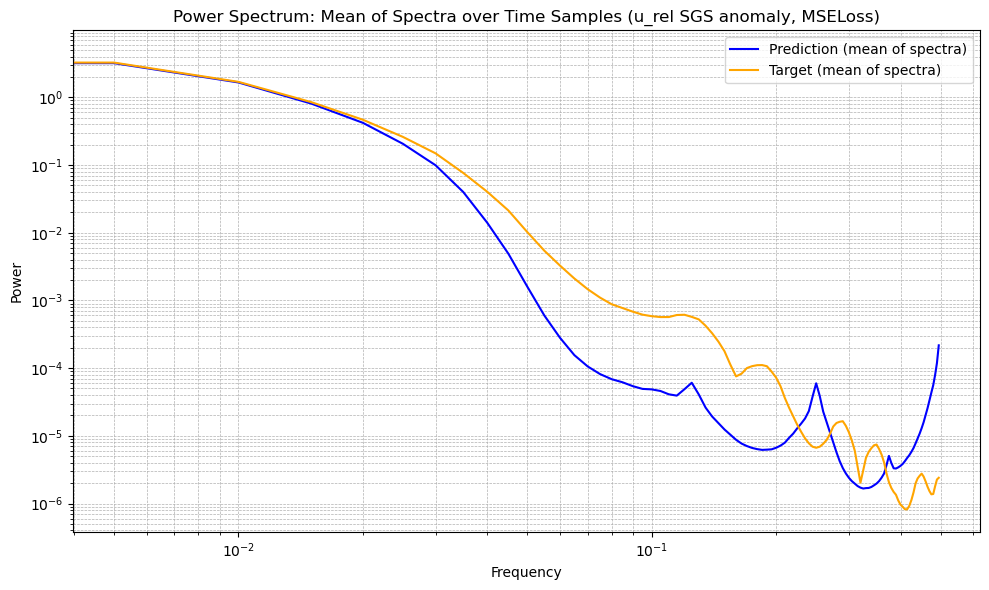

In [13]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(sr_pred.shape[-2]),
    'xt_ocean': range(sr_pred.shape[-1])
}

# Function to compute average power spectrum across samples
def mean_spectrum_over_samples(data, dims, coords):
    ps_list = []
    for i in range(data.shape[0]):  # assuming dim 'time'
        sample = xr.DataArray(data[i], dims=dims, coords=coords).chunk({'xt_ocean': -1})
        ps = xrft.power_spectrum(sample, dim='xt_ocean', window=True).mean(dim='yt_ocean')
        ps_list.append(ps)
    return xr.concat(ps_list, dim='sample').mean(dim='sample')

# Compute averaged power spectra across samples
ps_pred = mean_spectrum_over_samples(sr_pred, dims, coords)
ps_targ = mean_spectrum_over_samples(urel_SGS_test, dims, coords)

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_pred.freq_xt_ocean, ps_pred, label='Prediction (mean of spectra)', color='blue')
plt.plot(ps_targ.freq_xt_ocean, ps_targ, label='Target (mean of spectra)', color='orange')

# Configure plot
plt.title("Power Spectrum: Mean of Spectra over Time Samples (u_rel SGS anomaly, MSELoss)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


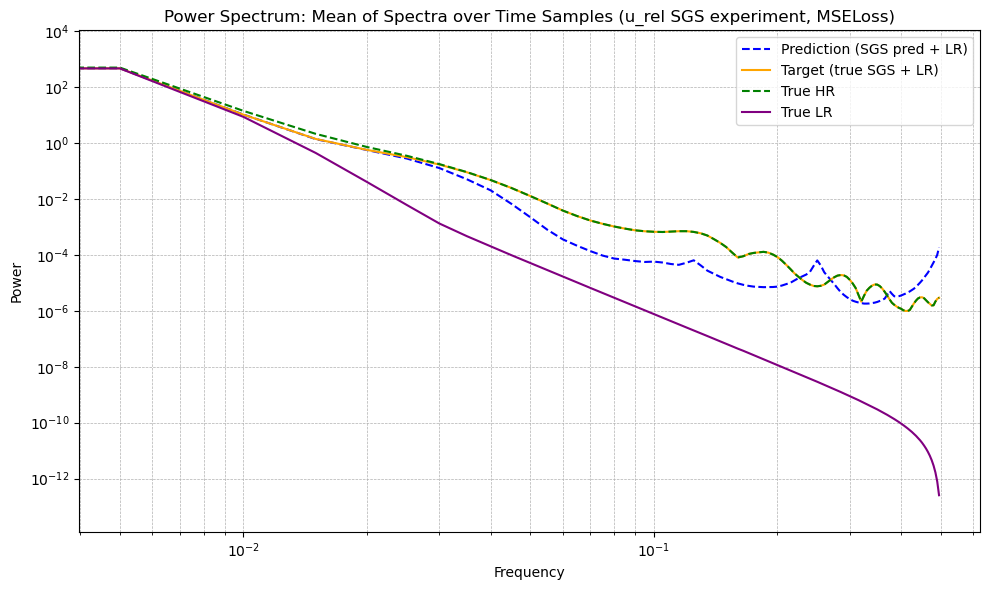

In [39]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(sr_pred.shape[-2]),
    'xt_ocean': range(sr_pred.shape[-1])
}

# Function to compute average power spectrum across samples
def mean_spectrum_over_samples(data, dims, coords):
    ps_list = []
    for i in range(data.shape[0]):  # assuming dim 'time'
        sample = xr.DataArray(data[i], dims=dims, coords=coords).chunk({'xt_ocean': -1})
        ps = xrft.power_spectrum(sample, dim='xt_ocean', window=True).mean(dim='yt_ocean')
        ps_list.append(ps)
    return xr.concat(ps_list, dim='sample').mean(dim='sample')

# Compute averaged power spectra across samples
ps_pred = mean_spectrum_over_samples(sr_pred, dims, coords)
ps_targ = mean_spectrum_over_samples(urel_SGS_test, dims, coords)
ps_LR = mean_spectrum_over_samples(urel_LR_test, dims, coords)
ps_HR = mean_spectrum_over_samples(urel_HR_test, dims, coords)

ps_HR_pred = ps_pred + ps_LR
ps_HR_true = ps_targ + ps_LR

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_HR_pred.freq_xt_ocean, ps_HR_pred, label='Prediction (SGS pred + LR)', linestyle='--', color='blue')
plt.plot(ps_HR_true.freq_xt_ocean, ps_HR_true, label='Target (true SGS + LR)', color='orange')
plt.plot(ps_HR.freq_xt_ocean, ps_HR, label='True HR', linestyle='--', color='green')
plt.plot(ps_LR.freq_xt_ocean, ps_LR, label='True LR', color='purple')

# Configure plot
plt.title("Power Spectrum: Mean of Spectra over Time Samples (u_rel SGS experiment, MSELoss)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


# Case 2: u_rel SGS anomaly prediction, CombinedLoss (alpha=1)

## Calculate gradients in CombinedLoss

In [12]:
# Define Sobel kernels
sobel_x = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
], dtype=np.float32)

sobel_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
], dtype=np.float32)

In [14]:
img = ds_SGS_reg.u_relative.isel(time=0)

# Compute gradients using convolution
grad_x = convolve(img, sobel_x, mode='constant', cval=0.0)
grad_y = convolve(img, sobel_y, mode='constant', cval=0.0)
grad_mag = np.sqrt(grad_x**2 + grad_y**2)
grad_mag

array([[2.3079636 , 2.2037966 , 2.2297611 , ..., 1.182891  , 1.1833124 ,
        1.2321703 ],
       [2.1864235 , 0.11344014, 0.09382026, ..., 0.06544997, 0.07635881,
        1.1640098 ],
       [2.2071075 , 0.04163731, 0.06874823, ..., 0.18551075, 0.20377402,
        1.1443876 ],
       ...,
       [1.6347623 , 0.34322208, 0.36978647, ..., 0.13640869, 0.17033617,
        0.9666305 ],
       [1.6079879 , 0.35778794, 0.3827552 , ..., 0.19046135, 0.19967468,
        0.90291965],
       [1.7485805 , 1.6276349 , 1.4550745 , ..., 0.9704738 , 0.90476954,
        0.9014178 ]], shape=(300, 200), dtype=float32)

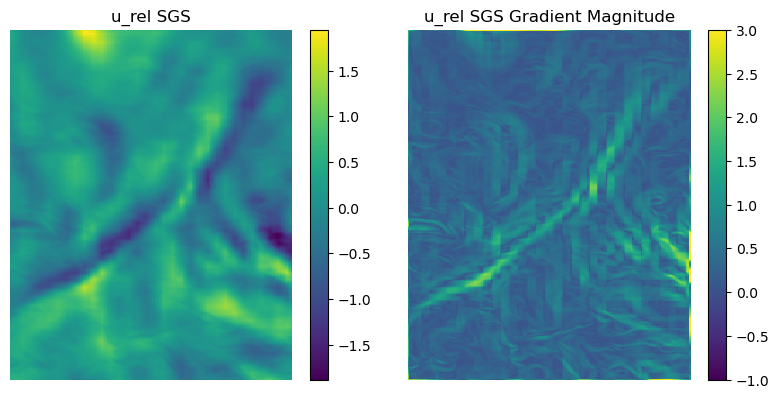

In [15]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjusted figure size

# Plot the high-resolution data
im1 = axes[0].pcolor(ds_SGS_reg.u_relative.isel(time=0))
axes[0].set_title("u_rel SGS")
axes[0].axis('off')  # Turn off the axes
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot the low-resolution data
im2 = axes[1].pcolor(grad_mag, vmin=-1, vmax=3)
axes[1].set_title("u_rel SGS Gradient Magnitude")
axes[1].axis('off')  # Turn off the axes
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Add space between subplots
plt.subplots_adjust(wspace=20)  # Increase space between plots

# Adjust layout to center the plots
plt.tight_layout()

# Show the plot
plt.show()

In [40]:
criterion = CombinedLoss(alpha=1) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_case_urelSGS_alph1.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 2.456e-01, Val Loss: 3.468e-01, Epoch Time: 204.17s
Model saved at epoch 1
Epoch 2, Train Loss: 1.733e-01, Val Loss: 1.656e-01, Epoch Time: 229.28s
Model saved at epoch 2


KeyboardInterrupt: 

In [ ]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, urel_SGS_test, './model_case_urelSGS_alph1.pth')
sr_pred

In [ ]:
num_samples = 5

# Create figure with 5 rows and 3 columns
fig, axs = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

# Now plot all images with shared vmin/vmax
for i in range(num_samples):
    d1 = urel_LR_test[i,:,:] 
    d2 = urel_SGS_test[i,:,:]
    d3 = sr_pred[i,:,:]

    # Min/Max Calculation
    # vmin = min(d2.min().compute().item(), d3.min().compute().item())
    # vmax = max(d2.max().compute().item(), d3.max().compute().item())
    
    # Input (LR)
    im1 = axs[i, 0].imshow(d1, cmap='viridis', vmin=d1.min().item(), vmax=d1.max().item())
    if i == 0:
        axs[i, 0].set_title('Input (LR)')
    plt.colorbar(im1, ax=axs[i, 0], fraction=0.046, pad=0.04)

    # Output (HR)
    im2 = axs[i, 1].imshow(d2, cmap='viridis', vmin=-1, vmax=1)
    if i == 0:
        axs[i, 1].set_title('Target (SGS)')
    plt.colorbar(im2, ax=axs[i, 1], fraction=0.046, pad=0.04)

    # Prediction (SR)
    im3 = axs[i, 2].imshow(d3, cmap='viridis', vmin=-1, vmax=1)
    if i == 0:
        axs[i, 2].set_title('Prediction (SRish)')
    plt.colorbar(im3, ax=axs[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(sr_pred.shape[-2]),
    'xt_ocean': range(sr_pred.shape[-1])
}

# Function to compute average power spectrum across samples
def mean_spectrum_over_samples(data, dims, coords):
    ps_list = []
    for i in range(data.shape[0]):  # assuming dim 'time'
        sample = xr.DataArray(data[i], dims=dims, coords=coords).chunk({'xt_ocean': -1})
        ps = xrft.power_spectrum(sample, dim='xt_ocean', window=True).mean(dim='yt_ocean')
        ps_list.append(ps)
    return xr.concat(ps_list, dim='sample').mean(dim='sample')

# Compute averaged power spectra across samples
ps_pred = mean_spectrum_over_samples(sr_pred, dims, coords)
ps_targ = mean_spectrum_over_samples(urel_SGS_test, dims, coords)

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_pred.freq_xt_ocean, ps_pred, label='Prediction (mean of spectra)', color='blue')
plt.plot(ps_targ.freq_xt_ocean, ps_targ, label='Target (mean of spectra)', color='orange')

# Configure plot
plt.title("Power Spectrum: Mean of Spectra over Time Samples (u_rel SGS anomaly, MSELoss)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(sr_pred.shape[-2]),
    'xt_ocean': range(sr_pred.shape[-1])
}

# Function to compute average power spectrum across samples
def mean_spectrum_over_samples(data, dims, coords):
    ps_list = []
    for i in range(data.shape[0]):  # assuming dim 'time'
        sample = xr.DataArray(data[i], dims=dims, coords=coords).chunk({'xt_ocean': -1})
        ps = xrft.power_spectrum(sample, dim='xt_ocean', window=True).mean(dim='yt_ocean')
        ps_list.append(ps)
    return xr.concat(ps_list, dim='sample').mean(dim='sample')

# Compute averaged power spectra across samples
ps_pred = mean_spectrum_over_samples(sr_pred, dims, coords)
ps_targ = mean_spectrum_over_samples(urel_SGS_test, dims, coords)
ps_LR = mean_spectrum_over_samples(urel_LR_test, dims, coords)
ps_HR = mean_spectrum_over_samples(urel_HR_test, dims, coords)

ps_HR_pred = ps_pred + ps_LR
ps_HR_true = ps_targ + ps_LR

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_HR_pred.freq_xt_ocean, ps_HR_pred, label='Prediction (SGS pred + LR)', linestyle='--', color='blue')
plt.plot(ps_HR_true.freq_xt_ocean, ps_HR_true, label='Target (true SGS + LR)', color='orange')
plt.plot(ps_HR.freq_xt_ocean, ps_HR, label='True HR', linestyle='--', color='green')
plt.plot(ps_LR.freq_xt_ocean, ps_LR, label='True LR', color='purple')

# Configure plot
plt.title("Power Spectrum: Mean of Spectra over Time Samples (u_rel SGS experiment, MSELoss)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()
